In [ ]:
!pip install yfinance nltk transformers datasets pandas numpy matplotlib tensorflow scikit-learn

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv('/content/news_stock_price.csv')  # Replace with your path
print(df.head())

# Check columns and data types
print(df.columns)
print(df.info())

         date                                                url  \
0  2022-10-08  https://www.livemint.com/market/stock-market-n...   
1  2022-10-08  https://www.zawya.com/en/markets/equities/wall...   
2  2022-10-08  https://www.goodisonnews.com/2022/10/08/stock-...   
3  2022-10-08  https://www.livemint.com/market/stock-market-n...   
4  2022-10-08  https://finance.yahoo.com/news/crypto-exchange...   

                                           full_text  \
0  Have you read your account statements for the ...   
1  Wall Street fell sharply on Friday following a...   
2  By Matthew Shaw 8th Oct, 2022 | 8:10am\n\nStoc...   
3  Stock split 2022: The board of directors of An...   
4  (Reuters) - Cryptocurrency exchange Huobi Glob...   

                                             summary  voo_close  voo_volume  \
0  And it’s natural to avoid looking too closely ...        NaN         NaN   
1  Nonfarm payrolls rose by 263,000 jobs, more th...        NaN         NaN   
2  By Matthew Sha

In [ ]:
df['date'] = pd.to_datetime(df['date'])  # Convert to datetime
df = df.sort_values('date', ascending=True)  # Sort chronologically

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters/numbers
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

df['cleaned_text'] = df['full_text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Fill missing values (if any)
df['voo_close'] = df['voo_close'].fillna(method='ffill')  # Forward fill

# Optional: Normalize closing prices
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['voo_close_scaled'] = scaler.fit_transform(df[['voo_close']])

<ipython-input-7-c3bfee38ce82>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['voo_close'] = df['voo_close'].fillna(method='ffill')  # Forward fill


In [ ]:
df['prev_voo_close'] = df['voo_close'].shift(1)  # Previous day's closing price

In [ ]:
df['5_day_MA'] = df['voo_close'].rolling(5).mean()  # 5-day moving average

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

df['vader_score'] = df['cleaned_text'].apply(
    lambda x: sid.polarity_scores(x)['compound']
)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
!pip install tf-keras

In [ ]:
from transformers import pipeline
import torch

# Use GPU if available
finbert = pipeline(
    "text-classification",
    model="ProsusAI/finbert",
    device=0 if torch.cuda.is_available() else -1,
    truncation=True
)

# Batch processing for efficiency
def get_finbert_sentiment(texts):
    results = finbert(texts)
    return [result['label'].lower() for result in results]

# Process headlines in batches (adjust batch_size based on GPU memory)
batch_size = 32
headlines = df['full_text'].tolist()
finbert_sentiments = []

for i in range(0, len(headlines), batch_size):
    batch = headlines[i:i+batch_size]
    sentiments = get_finbert_sentiment(batch)
    finbert_sentiments.extend(sentiments)

df['finbert_sentiment'] = finbert_sentiments

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Load labeled financial data
phrasebank = load_dataset("financial_phrasebank", "sentences_50agree")
train_sentences = phrasebank['train']['sentence']
train_labels = phrasebank['train']['label']

# Vectorize text
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_sentences)
y_train = train_labels

# Train SVM
svm = SVC()
svm.fit(X_train, y_train)

# Predict on your headlines
X_custom = vectorizer.transform(df['cleaned_text'])
df['svm_sentiment'] = svm.predict(X_custom)

README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

The repository for financial_phrasebank contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/financial_phrasebank.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

In [ ]:
# Lagged closing price
df['prev_close'] = df['voo_close'].shift(1)

# 5-day moving average
df['5_day_MA'] = df['voo_close'].rolling(5).mean()

# Drop missing values
df.dropna(inplace=True)

In [ ]:
# Convert sentiment labels to numerical scores
sentiment_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df['finbert_score'] = df['finbert_sentiment'].map(sentiment_map)
df['svm_score'] = df['svm_sentiment'].map(sentiment_map)

In [ ]:
# Lagged closing price
df['prev_close'] = df['voo_close'].shift(1)

# 5-day moving average
df['5_day_MA'] = df['voo_close'].rolling(5).mean()

# Instead of dropping all rows with NaNs, fill them with appropriate values
# For example, you could use forward fill or backward fill for price-related features
df['prev_close'] = df['prev_close'].fillna(method='ffill')
df['5_day_MA'] = df['5_day_MA'].fillna(method='bfill')

# If sentiment scores have missing values, you can fill them with 0 (neutral)
df['vader_score'] = df['vader_score'].fillna(0)
df['finbert_score'] = df['finbert_score'].fillna(0)
df['svm_score'] = df['svm_score'].fillna(0)

# You've already filled sentiment scores with mean in previous cells, so no changes are needed here

# Now, drop rows only if they still contain missing values in essential columns
# (e.g., 'voo_close', 'prev_close', '5_day_MA', 'vader_score', 'finbert_score', 'svm_score')
essential_columns = ['voo_close', 'prev_close', '5_day_MA', 'vader_score', 'finbert_score', 'svm_score']
df.dropna(subset=essential_columns, inplace=True)

<ipython-input-16-cfb020998b45>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['prev_close'] = df['prev_close'].fillna(method='ffill')
<ipython-input-16-cfb020998b45>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['5_day_MA'] = df['5_day_MA'].fillna(method='bfill')


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split data
split_idx = int(0.8 * len(df))
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Features: Price history + sentiment
features_vader = ['prev_close', '5_day_MA', 'vader_score']
features_finbert = ['prev_close', '5_day_MA', 'finbert_score']
features_svm = ['prev_close', '5_day_MA', 'svm_score']

# Train models
def train_evaluate_regression(features, model_name):
    X_train = train[features]
    y_train = train['voo_close']
    X_test = test[features]
    y_test = test['voo_close']

    model = LinearRegression() if model_name == 'Linear' else Ridge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred)**0.5
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Regression (RMSE): {rmse:.2f}, R²: {r2:.2f}")
    return y_pred

# Evaluate for each sentiment approach
for features, approach in zip([features_vader, features_finbert, features_svm],
                              ['VADER', 'FinBERT', 'SVM']):
    print(f"\n{approach} Sentiment:")
    train_evaluate_regression(features, 'Linear')
    train_evaluate_regression(features, 'Ridge')
    y_test_regression_vader = test['voo_close']  # Actual values for VADER regression
    y_pred_regression_vader = train_evaluate_regression(features_vader, 'Linear')
    y_test_regression_finbert = test['voo_close']  # Actual values for FinBERT regression
    y_pred_regression_finbert = train_evaluate_regression(features_finbert, 'Linear')
    y_test_regression_svm = test['voo_close']  # Actual values for SVM regression
    y_pred_regression_svm = train_evaluate_regression(features_svm, 'Linear')
    date_values = df['date'].values[split_idx:]



VADER Sentiment:
Linear Regression (RMSE): 1.36, R²: 0.99
Ridge Regression (RMSE): 1.36, R²: 0.99
Linear Regression (RMSE): 1.36, R²: 0.99
Linear Regression (RMSE): 1.36, R²: 0.99
Linear Regression (RMSE): 1.36, R²: 0.99

FinBERT Sentiment:
Linear Regression (RMSE): 1.36, R²: 0.99
Ridge Regression (RMSE): 1.36, R²: 0.99
Linear Regression (RMSE): 1.36, R²: 0.99
Linear Regression (RMSE): 1.36, R²: 0.99
Linear Regression (RMSE): 1.36, R²: 0.99

SVM Sentiment:
Linear Regression (RMSE): 1.36, R²: 0.99
Ridge Regression (RMSE): 1.36, R²: 0.99
Linear Regression (RMSE): 1.36, R²: 0.99
Linear Regression (RMSE): 1.36, R²: 0.99
Linear Regression (RMSE): 1.36, R²: 0.99


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for LSTM
def prepare_lstm_data(features):
    X = df[features].values
    y = df['voo_close'].values

    # Reshape for LSTM [samples, timesteps, features]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    return X, y

# Train LSTM for each sentiment approach
for features, approach in zip([features_vader, features_finbert, features_svm],
                              ['VADER', 'FinBERT', 'SVM']):
    X, y = prepare_lstm_data(features)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    model = Sequential()
    model.add(LSTM(50, activation='tanh', recurrent_activation='sigmoid', input_shape=(1, len(features))))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # Evaluate
    y_pred = model.predict(X_test).flatten()

    # Calculate RMSE manually (for older scikit-learn versions)
    mse = mean_squared_error(y_test, y_pred)  # Calculate MSE
    rmse = np.sqrt(mse)  # Calculate RMSE from MSE

    r2 = r2_score(y_test, y_pred)
    print(f"\n{approach} LSTM (RMSE): {rmse:.2f}, R²: {r2:.2f}")
    y_test_lstm_vader = test['voo_close']  # Actual values for VADER LSTM
    y_pred_lstm_vader = model.predict(X_test).flatten()
    y_test_lstm_finbert = test['voo_close']  # Actual values for FinBERT LSTM
    y_pred_lstm_finbert = model.predict(X_test).flatten()
    y_test_lstm_svm = test['voo_close']  # Actual values for SVM LSTM
    y_pred_lstm_svm = model.predict(X_test).flatten()
    date_values = df['date'].values[split_idx:]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

VADER LSTM (RMSE): 339.69, R²: -319.87
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

FinBERT LSTM (RMSE): 345.44, R²: -330.81
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

SVM LSTM (RMSE): 341.29, R²: -322.89
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


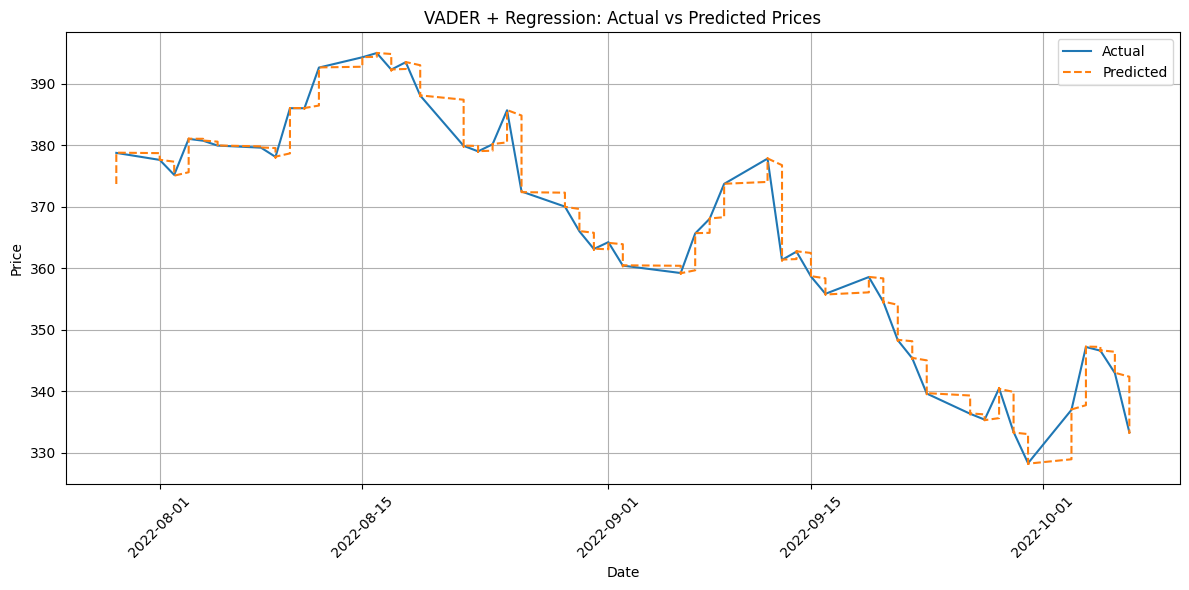

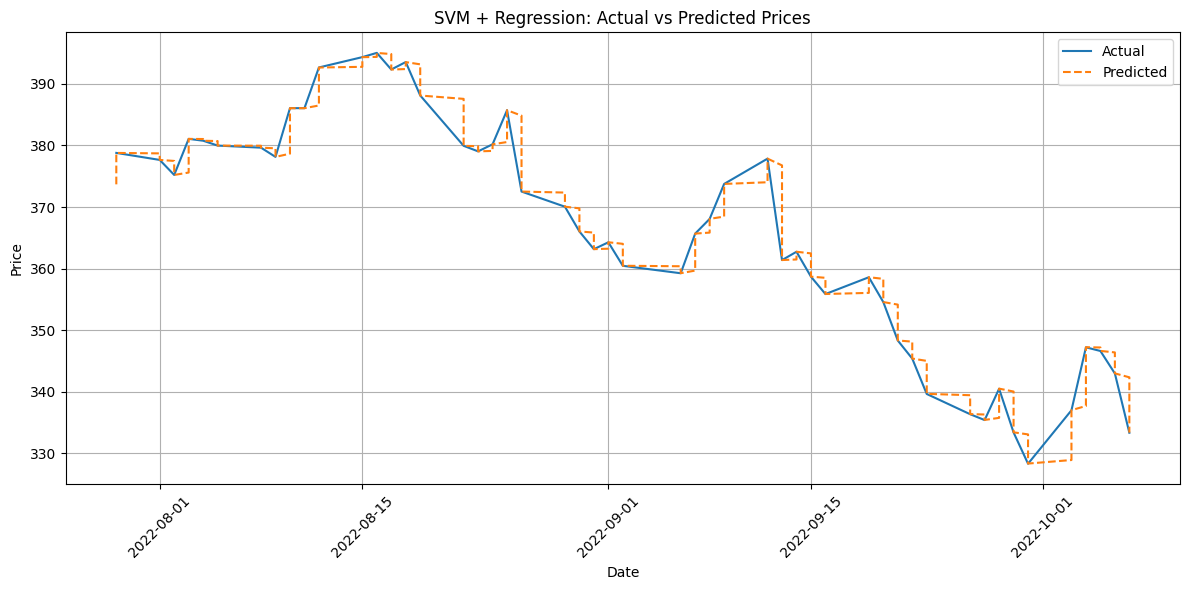

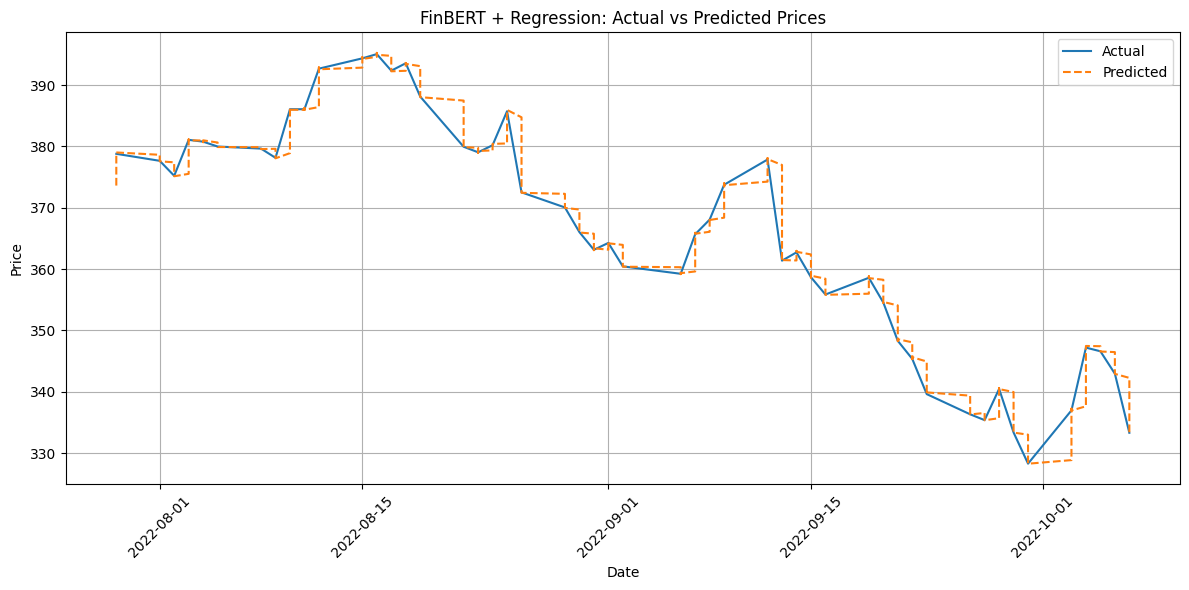

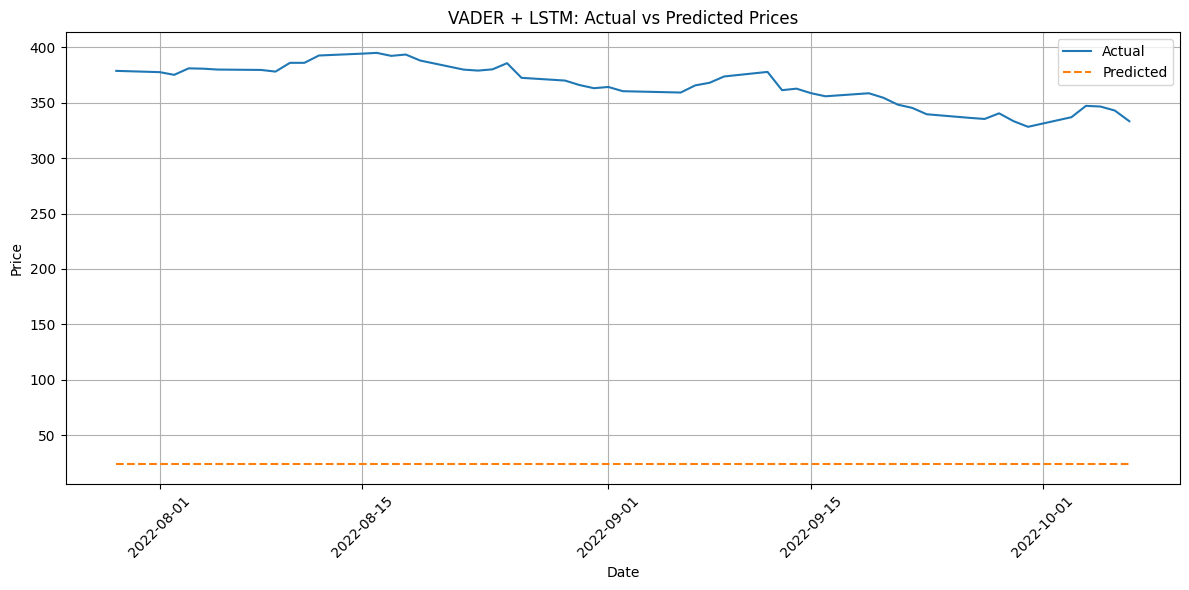

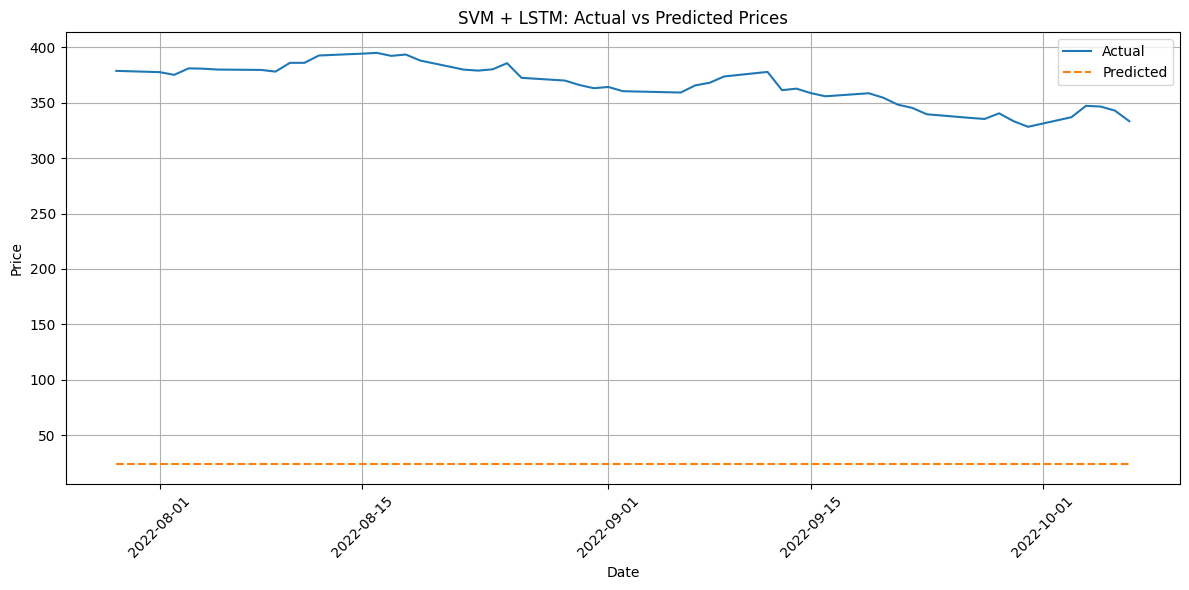

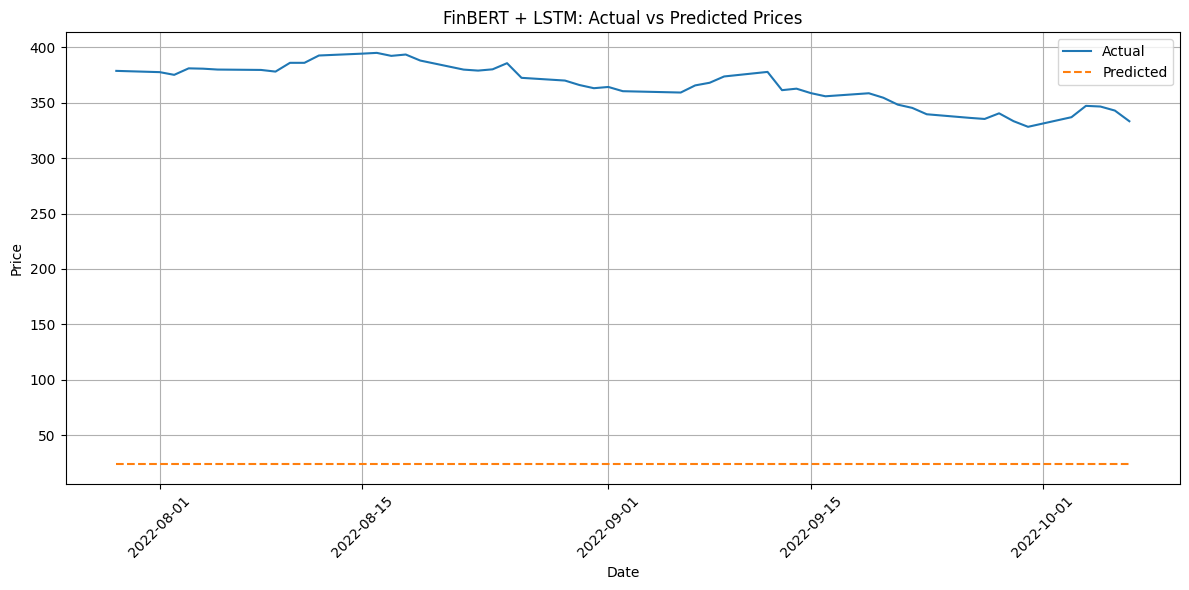

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already trained and obtained predictions for all models

# Function to plot actual vs predicted
def plot_actual_vs_predicted(y_test, y_pred, title, date_values):
    plt.figure(figsize=(12, 6))
    plt.plot(date_values, y_test, label='Actual')
    plt.plot(date_values, y_pred, label='Predicted', linestyle='--')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

# Assuming you have the following variables:
# - y_test_regression_vader, y_pred_regression_vader
# - y_test_regression_svm, y_pred_regression_svm
# - y_test_regression_finbert, y_pred_regression_finbert
# - y_test_lstm_vader, y_pred_lstm_vader
# - y_test_lstm_svm, y_pred_lstm_svm
# - y_test_lstm_finbert, y_pred_lstm_finbert

# Also assuming you have a 'date_values' variable containing the corresponding dates

# Plot for each combination
plot_actual_vs_predicted(y_test_regression_vader, y_pred_regression_vader,
                         'VADER + Regression: Actual vs Predicted Prices', date_values)
plot_actual_vs_predicted(y_test_regression_svm, y_pred_regression_svm,
                         'SVM + Regression: Actual vs Predicted Prices', date_values)
plot_actual_vs_predicted(y_test_regression_finbert, y_pred_regression_finbert,
                         'FinBERT + Regression: Actual vs Predicted Prices', date_values)
plot_actual_vs_predicted(y_test_lstm_vader, y_pred_lstm_vader,
                         'VADER + LSTM: Actual vs Predicted Prices', date_values)
plot_actual_vs_predicted(y_test_lstm_svm, y_pred_lstm_svm,
                         'SVM + LSTM: Actual vs Predicted Prices', date_values)
plot_actual_vs_predicted(y_test_lstm_finbert, y_pred_lstm_finbert,
                         'FinBERT + LSTM: Actual vs Predicted Prices', date_values)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import MinMaxScaler

# Focus on VOO ETF (S&P 500)
target_col = 'voo_close'
features = ['prev_voo_close', '5_day_MA', 'vader_score', 'finbert_score']

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + [target_col]])

# Create sequences for Transformer (window_size = historical days to use)
window_size = 30  # Use 30 days of history to predict next day
X, y = [], []
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size, :-1])  # Input features (exclude target)
    y.append(scaled_data[i+window_size, -1])     # Target (next day's close)
X, y = np.array(X), np.array(y)

# Split into train/test (80/20)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    res = x + inputs  # Residual connection

    # Feed-forward network
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.1,
):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Global average pooling and MLP
    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(1)(x)  # Predict next day's close
    return Model(inputs, outputs)

# Hyperparameters
input_shape = (window_size, len(features))
model = build_transformer(
    input_shape=input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    mlp_units=[64],
    dropout=0.2,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 4)     │      4,868 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 4)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 4)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 4)     │          8 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │        640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 128)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 4)     │        516 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 4)     │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 4)     │      4,868 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30, 4)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 4)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 4)     │          8 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 30, 128)   │        640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 4)     │        516 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 30, 4)     │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 4)         │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense[0][0]     

 Total params: 12,449 (48.63 KB)

 Trainable params: 12,449 (48.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train with early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - loss: 0.0871 - mae: 0.2225 - val_loss: 0.0028 - val_mae: 0.0408
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0131 - mae: 0.0902 - val_loss: 0.0038 - val_mae: 0.0500
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - mae: 0.0794 - val_loss: 0.0063 - val_mae: 0.0656
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - mae: 0.0784 - val_loss: 0.0055 - val_mae: 0.0615
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0082 - mae: 0.0711 - val_loss: 0.0079 - val_mae: 0.0766
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0085 - mae: 0.0723 - val_loss: 0.0035 - val_mae: 0.0498
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - mae: 0.0654 - val_loss: 0.0063 - val_mae: 0.0673
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - mae: 0.0686 - val_loss: 0.0046 - val_mae: 0.0567
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

In [ ]:
# Predict on test data
y_pred = model.predict(X_test).flatten()

# Inverse transform predictions to original scale
y_test_orig = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_test), len(features))),
    y_test.reshape(-1, 1)
], axis=1))[:, -1]

y_pred_orig = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_pred), len(features))),
    y_pred.reshape(-1, 1)
], axis=1))[:, -1]

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE: 5.71
R²: 0.91


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 5.71
R²: 0.91


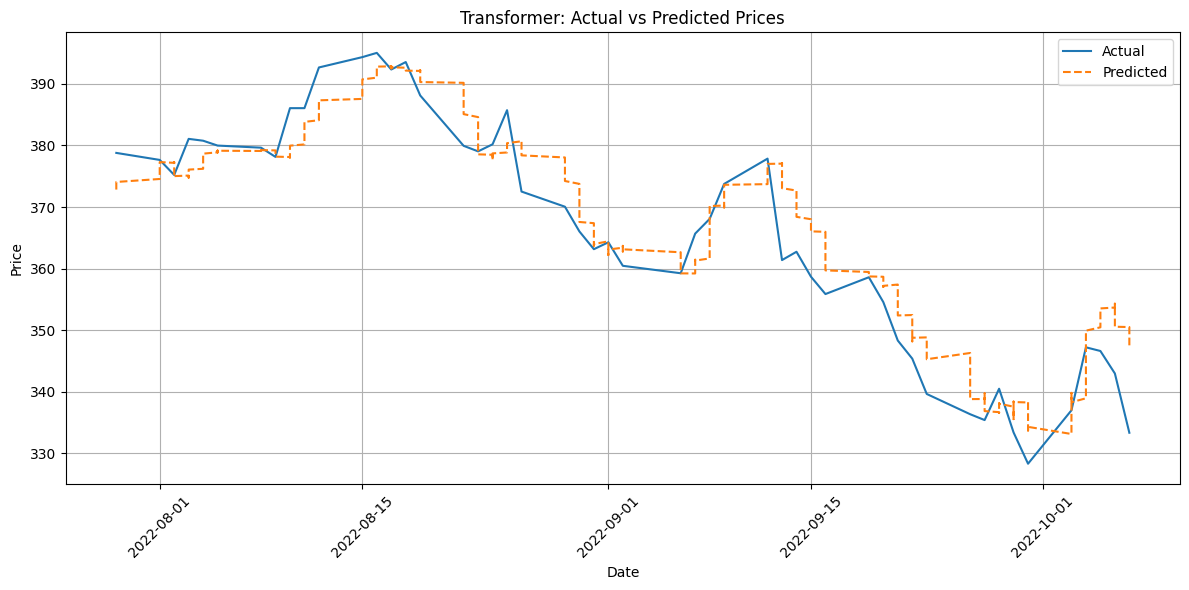

In [ ]:
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test).flatten()

# Inverse transform predictions to original scale
y_test_orig = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_test), len(features))),
    y_test.reshape(-1, 1)
], axis=1))[:, -1]

y_pred_orig = scaler.inverse_transform(np.concatenate([
    np.zeros((len(y_pred), len(features))),
    y_pred.reshape(-1, 1)
], axis=1))[:, -1]

# Calculate metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2 = r2_score(y_test_orig, y_pred_orig)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6)) # Now plt is defined and can be used
plt.plot(df['date'].values[-len(y_test_orig):], y_test_orig, label='Actual')
plt.plot(df['date'].values[-len(y_pred_orig):], y_pred_orig, label='Predicted', linestyle='--')
plt.title('Transformer: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print(df_plot.dtypes)  # Ensure `date` is datetime, others are numeric

date         datetime64[ns]
Actual                int64
Predicted           float64
dtype: object


In [ ]:
print(df_plot.head())  # Confirm dates match actual/predicted values

        date  Actual  Predicted
0 2022-08-01     100       98.0
1 2022-08-02     101       99.5
2 2022-08-03     102      101.0
3 2022-08-04     103      101.0
4 2022-08-05     104      102.5
